# Leigh Ann Kudloff and Nataly Valenzuela Mullen 
# Final Project--Data Science Tools 1  
# Winter 2021

## I.	Introduction/Story
### Like most Data Science students, concern about job opportunities in the near future loom heavily at the halfway point of this degree program.  In one year, employment is necessary to pay off student loans and enter the world of data science.  This project focuses on the world of job hunting in Data Science.  The goal is to explore job descriptions to categorize skill sets, look for patterns, and prepare tools for the job hunt later this year.  Through the exploration of trends in data science job postings, the concepts learned from Data Science Tools 1 and other classes will be applied and hopefully the ideal jobs will emerge.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pandas_profiling  as pp
import plotly.express    as px
import re

from mpl_toolkits.mplot3d    import Axes3D
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance  import pdist
from sklearn                 import datasets
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA
from sklearn.metrics         import confusion_matrix

import string
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

In [2]:
df1 = pd.read_csv("DataScienceJobs.csv")

df1 = df1[["Job Title", "Job Description", "Company Name", "City", "State", "Size", 
           "Years_Founded", "Industry", "Rating", "Min_Salary", "Max_Salary", "Est_Salary"]]

strCols = df1.select_dtypes(['object']).columns
df1[strCols] = df1[strCols].apply(lambda x: x.str.strip())

# Used this code to adjust UK jobs for US:  
                                            #df1[df1.State.isin(["United Kingdom"])]
                                            #df1.iloc[1870]["Job Description"]
df1.iloc[1637,3]="Upper Providence"
df1.iloc[1784,3]="Upper Providence"
df1.iloc[1799,3]="Upper Providence"
df1.iloc[1870,3]="Philadelphia"
df1.iloc[[1637, 1784, 1799, 1870], 4]="PA"

# Create Location by joining columns--City and State
df1["Location"]=df1["City"] +", " + df1["State"]

# Creating a column for Remote work
df1.loc[df1["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df1["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1_to_50_employees": "Very Small", 
           "51_to_200_employees": "Small",
          "201_to_500_employees": "Medium-Small",
          "501_to_1000_employees": "Medium",
          "1001_to_5000_employees": "Medium-Large",
          "5001_to_10000_employees": "Large",
          "10000_employees": "Very Large"}
df1["Size"].replace(sizeKey, inplace=True)

df1.rename({"Min_Salary": "SalaryMin", "Max_Salary": "SalaryMax", "Est_Salary": "Salary Estimate"}, 
                  axis=1, inplace=True)

#Changing Years_Founded to Founded
df1["Founded"]=2020-df1["Years_Founded"]
df1.drop(["Years_Founded"], axis=1, inplace=True)

# Removing underscores from Industry
df1["Industry"]=df1["Industry"].replace("_", " ", regex=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF1=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF1duplicates=df1[df1.duplicated(criteriaDF1)].sort_values(by=criteriaDF1)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df1=df1[~df1.duplicated(criteriaDF1)]

# Dataframe Label
df1["DF"]= "DF1"

# Reordered Columns for Readability
df1 = df1.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote", 
                                             "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df1.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

print(DF1duplicates.shape)
print(df1.shape)
#df1.head(10)
#df1.State.value_counts()
list(df1.Size.unique())
df1.sample(10)

(21, 14)
(12339, 15)


Job Title  \
12347  Research Director / Analyst -- Enterprise Data...   
6906                        Senior Data Engineer - C3.ai   
456     Business Analytics Manager, Enterprise Marketing   
1630                               Data Engineer- Python   
755                 Data Scientist / Statistical Modeler   
3228                               Senior Data Scientist   
10840                  Federal - Appian Business Analyst   
859                                        Data Engineer   
823                    Software Engineer - Data Platform   
5667                             Data Validation Analyst   

                                         Job Description  \
12347  Job Description\nLots of people talk about "ma...   
6906   Position Title: Senior Data Engineer - C3.ai\n...   
456    The Analytics team at Miro has a clear mission...   
1630   We are looking for a motivated Data Engineer w...   
755    Address: 111 W Monroe - 115 S LaSalle Job Fami...   
3228   The online travel market never stands still. A...   
10840  Organization: Accenture Federal ServicesLocati...   
859    Job Title: Data EngineerCompanyWork matters. I...   
823    The Job Details are as follows:\n\nROLE OVERVI...   
5667   OUR GOAL:\nTreat our consultants and clients t...   

                          Company Name          Location          City State  \
12347                         GasPedal        Austin, TX        Austin    TX   
6906                          Skiltrek       Houston, TX       Houston    TX   
456                               Miro   Los Angeles, CA   Los Angeles    CA   
1630   Becker Technical Staffing, Inc.  Philadelphia, PA  Philadelphia    PA   
755                BMO Financial Group       Chicago, IL       Chicago    IL   
3228                        Hotels.com        Austin, TX        Austin    TX   
10840        Accenture Contractor Jobs   San Antonio, TX   San Antonio    TX   
859                         ServiceNow       Chicago, IL       Chicago    IL   
823          Balyasny Asset Management       Chicago, IL       Chicago    IL   
5667                          Revel IT        Dublin, OH        Dublin    OH   

          Remote          Size  Founded  \
12347        Yes    Very Small   2007.0   
6906   Uncertain         Small      NaN   
456    Uncertain  Medium-Small   2015.0   
1630   Uncertain    Very Small      NaN   
755    Uncertain    Very Large   1817.0   
3228   Uncertain   SizeUnknown   1991.0   
10840  Uncertain           NaN      NaN   
859    Uncertain    Very Large   2004.0   
823    Uncertain        Medium   2001.0   
5667   Uncertain  Medium-Small   1997.0   

                                    Industry  Rating  SalaryMin  SalaryMax  \
12347               Membership Organizations     3.5         58        103   
6906                                     NaN     NaN         54        113   
456               Computer Hardware Software     4.5        134        218   
1630                    Staffing Outsourcing     2.8         50         87   
755                      Banks Credit Unions     3.7         91        105   
3228                                Internet     3.6        112        178   
10840                                    NaN     NaN         48         74   
859    Enterprise Software Network Solutions     3.7         99        174   
823      Investment Banking Asset Management     3.9         39         81   
5667                             IT Services     5.0         28         52   

       Salary Estimate   DF  
12347             80.5  DF1  
6906              83.5  DF1  
456              176.0  DF1  
1630              68.5  DF1  
755               98.0  DF1  
3228             145.0  DF1  
10840             61.0  DF1  
859              136.5  DF1  
823               60.0  DF1  
5667              40.0  DF1

In [3]:
df2 = pd.read_csv("DataScientist.csv")

df2 = df2[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = df2.select_dtypes(['object']).columns
df2[strCols] = df2[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# df2[df2.State.isin(["United Kingdom"])]
#print(df2.State.value_counts())
#print(df2[df2.State.isin([" United Kingdom"])])

df2.iloc[1647,3]="Upper Providence, PA"
df2.iloc[1794,3]="Upper Providence, PA"
df2.iloc[1809,3]="Upper Providence, PA"
df2.iloc[1880,3]="Philadelphia, PA"

# Split Location into new columns--City and State
df2[["City", "State"]]= df2["Location"].str.split(",", n = 1, expand = True)
df2.loc[(~df2["Location"].str.contains(",")), "State"]=df2.loc[(~df2["Location"].str.contains(",")),"City"]
df2["State"]=df2["State"].str.strip()
df2.loc[(~df2["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
df2.loc[(df2["Location"]=="Remote"), "Remote"]="Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
df2.loc[(df2["Location"]=="Remote"), "State"]=np.nan

# Creating a column for Remote work
df2.loc[df2["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
df2[["SalaryTest", "Salary"]] = df2["Salary Estimate"].str.split("(", n = 1, expand = True)
df2[["SalaryMin", "SalaryMax"]]= df2["SalaryTest"].str.split("-", n = 1, expand = True)
df2.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
df2["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
df2["SalaryMin"]=df2["SalaryMin"].replace("[$K]","",regex=True)
df2["SalaryMax"]=df2["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
df2["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
df2[["Company Name", "RateTest"]] = df2["Company Name"].str.split("\n", n=1, expand = True)
df2.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF2=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF2duplicates=df2[df2.duplicated(criteriaDF2)].sort_values(by=criteriaDF2)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df2=df2[~df2.duplicated(criteriaDF2)]

# Dataframe Label
df2["DF"]= "DF2"

# Reordered Columns for Readability
df2 = df2.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote",
                              "Size", "Founded", "Industry", "Rating", "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df2.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

#print(DF2duplicates.shape)
print(df2.shape)
df2.sample(10)

(3909, 15)


Job Title  \
1619                                 Research Scientist   
251                           Machine Learning Engineer   
108                                        Data Analyst   
2167                                       Data Analyst   
3653                       Data Engineer/Data Scientist   
3875                                  Big Data Engineer   
2903                              Senior Data Scientist   
622                                Product Data Analyst   
3031                    Data Engineer, Machine Learning   
485   Artificial Intelligence/Machine Learning Engineer   

                                        Job Description  \
1619  The Ellman Lab is looking for a Research Scien...   
251   Role: Machine Learning Engineer\n\nLocation: L...   
108   The Data Analyst is an integral member of the ...   
2167  At Seer, we pride ourselves on innovation; sta...   
3653  Job Title Data Engineer Location US-TX-Fort Wo...   
3875  Tiger Analytics is a fast-growing advanced ana...   
2903  We're looking for an exceptional Senior Data S...   
622   The Product Strategy Group works to ensure the...   
3031  At Cadence, we hire and develop leaders and in...   
485   Requisition ID: 51543\n\nAll Locations: El Seg...   

                   Company Name          Location          City State  \
1619          Temple University  Philadelphia, PA  Philadelphia    PA   
251          The Trevor Project      New York, NY      New York    NY   
108                        DMGT      New York, NY      New York    NY   
2167           Seer Interactive     San Diego, CA     San Diego    CA   
3653      United Software Group    Fort Worth, TX    Fort Worth    TX   
3875            Tiger Analytics      Columbus, OH      Columbus    OH   
2903                    Airtime     Palo Alto, CA     Palo Alto    CA   
622                  Stamps.com    El Segundo, CA    El Segundo    CA   
3031                    Cadence      San Jose, CA      San Jose    CA   
485   The Aerospace Corporation    El Segundo, CA    El Segundo    CA   

         Remote          Size  Founded                          Industry  \
1619  Uncertain         Large   1888.0           Colleges & Universities   
251   Uncertain         Small      NaN                 Social Assistance   
108   Uncertain         Large   1896.0  Venture Capital & Private Equity   
2167  Uncertain         Small   2002.0                          Internet   
3653  Uncertain  Medium-Small   2002.0                       IT Services   
3875        Yes  Medium-Small   2011.0                        Consulting   
2903  Uncertain         Small   2012.0                          Internet   
622   Uncertain  Medium-Large   1996.0      Computer Hardware & Software   
3031  Uncertain    Very Small   2014.0            Research & Development   
485   Uncertain  Medium-Large   1960.0               Aerospace & Defense   

      Rating SalaryMin SalaryMax  Salary Estimate   DF  
1619     4.1        93      151               NaN  DF2  
251      4.6       133      171               NaN  DF2  
108      4.0       102      121               NaN  DF2  
2167     3.9        60      124               NaN  DF2  
3653     3.7        57       80               NaN  DF2  
3875     4.6        39       86               NaN  DF2  
2903     4.5       111      175               NaN  DF2  
622      3.2        37       75               NaN  DF2  
3031     4.7       135      214               NaN  DF2  
485      3.9        76      125               NaN  DF2

In [4]:
# column selection--unnecessary columns eliminated
dfGlassdoor = pd.read_csv("glassdoor_jobs.csv")
# print(list(dfGlassdoor.columns))
dfGlassdoor.drop(['Headquarters', 'Sector', 'Revenue', 'Competitors', 'Type of ownership'],axis = 1, inplace = True)

strCols = dfGlassdoor.select_dtypes(['object']).columns
dfGlassdoor[strCols] = dfGlassdoor[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# dfGlassdoor[dfGlassdoor.State.isin (["None", " Raleigh", " Anne Arundel, MD"])])

dfGlassdoor.iloc[297,5]="Patuxent, MD"
dfGlassdoor.iloc[136,5]="Raleigh, NC"
dfGlassdoor.iloc[320,5]="Remote"
dfGlassdoor.iloc[12,5]="Portland, OR"
dfGlassdoor.iloc[157,5]="Chicago, IL"
dfGlassdoor.iloc[163,5]="Pembroke Pines, Florida"
dfGlassdoor.iloc[11,5]="Holmdel, NJ"
dfGlassdoor.iloc[346,5]="Middlesex, NJ"
dfGlassdoor.iloc[757,5]="Arlington, VA"
dfGlassdoor.iloc[758,5]="Hollywood, CA"
dfGlassdoor.iloc[830,5]="Washington, DC"

# Split Location into new columns--City and State and make city nan
dfGlassdoor[["City", "State"]]= dfGlassdoor["Location"].str.split(",", n = 1, expand = True)
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "State"]=dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")),"City"]
dfGlassdoor["State"]=dfGlassdoor["State"].str.strip()
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "Remote"]="Yes"
dfGlassdoor["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfGlassdoor.loc[dfGlassdoor["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfGlassdoor[["SalaryTest", "Salary"]] = dfGlassdoor["Salary Estimate"].str.split("(", n = 1, expand = True)
dfGlassdoor[["SalaryMin", "SalaryMax"]]= dfGlassdoor["SalaryTest"].str.split("-", n = 1, expand = True)
dfGlassdoor.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfGlassdoor["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfGlassdoor["SalaryMin"]=dfGlassdoor["SalaryMin"].replace("[$K]","",regex=True)
dfGlassdoor["SalaryMax"]=dfGlassdoor["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfGlassdoor["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfGlassdoor[["Company Name", "RateTest"]] = dfGlassdoor["Company Name"].str.split("\n", n=1, expand = True)
dfGlassdoor.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaGD=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#GDduplicates=dfGlassdoor[dfGlassdoor.duplicated(criteriaGD)].sort_values(by=criteriaGD)
#testGD=GDduplicates.loc[GDduplicates["SalaryMin"].notnull()]
dfGlassdoor=dfGlassdoor[~dfGlassdoor.duplicated(criteriaGD)]

# Dataframe Label
dfGlassdoor["DF"]= "GD"

# Reordered Columns for Readability
dfGlassdoor = dfGlassdoor.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfGlassdoor.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfGlassdoor.fillna(value=np.nan, axis=1, inplace=True)
#dfGlassdoor["Founded"]=dfGlassdoor["Founded"].astype(int)--We found this did not work well.

#print(testGD.shape)
print(dfGlassdoor.shape)
dfGlassdoor.sample(20)


(899, 15)


Job Title  \
504  Lead Data Scientist – Network Analysis and Con...   
199                                Lead Data Scientist   
796                                     Data Scientist   
310                                  EPMO Data Analyst   
544                                     Data Scientist   
71   Lead Certified Clinical Laboratory Scientist -...   
853                                     Data Scientist   
514                                     Data Scientist   
775                                     Data Scientist   
858       Senior/Principal Scientist, Protein Sciences   
825                                     Data Scientist   
567                                     Data Scientist   
474                                     Data Scientist   
873                                     Data Scientist   
769                                     Data Scientist   
409                                     Data Scientist   
191             Senior Scientist - Product Development   
586                                 Research Scientist   
426                                     Data Scientist   
839                                     Data Scientist   

                                       Job Description  \
504  Why choose between doing meaningful work and h...   
199  At the intersection of technology, science, bu...   
796  Job Description\nWe are the most sought after ...   
310  Resp & Qualifications\nPURPOSE:\nThe Enterpris...   
544  Ke`aki Technologies is looking for a qualified...   
71   The Lead Certified Clinical Laboratory Scienti...   
853  Job Description – Data Scientist\n\nNowigence,...   
514  Role Data Scientist Location Redmond, WA Durat...   
775  Working in a high performing team as part of a...   
858  Rubius Therapeutics is a clinical-stage biopha...   
825  Job Description\nTiger Analytics is looking fo...   
567  Job Description\nResponsibilities:\nProvides e...   
474  Entefy’s Senior Data Scientist is a highly vis...   
873  Work experience as a Python Developer\nExperti...   
769  Facebook's mission is to give people the power...   
409  Data Scientist\nID\n\n4317\n\nLocation\n\n\nMe...   
191  Information about #20423 Senior Scientist - Pr...   
586  Serve as the technical expert for flavor ingre...   
426  Role Data Scientist Location Foster City, CA K...   
839  Company Description\n\n********************onl...   

                                        Company Name              Location  \
504                                            MITRE           Bedford, MA   
199                                           Strivr         Palo Alto, CA   
796                                          Averity          New York, NY   
310                   CareFirst BlueCross BlueShield        Washington, DC   
544         Alaka`ina Foundation Family of Companies  Fort Sam Houston, TX   
71                        Exact Sciences Corporation           Madison, WI   
853                                   Nowigence Inc.         Charlotte, NC   
514                         NexZen Tek Solutions Inc           Redmond, WA   
775                    Oscar Associates Americas LLC           Houston, TX   
858                              Rubius Therapeutics         Cambridge, MA   
825                                  Tiger Analytics            Denver, CO   
567  HireResources a Tailored Solutions Company (WO)          Richmond, VA   
474                                           Entefy         Palo Alto, CA   
873                                       TransReach     San Francisco, CA   
769                                         Facebook           Fremont, CA   
409                                         Exponent        Menlo Park, CA   
191                                             GOJO             Akron, OH   
586                                         Givaudan        Cincinnati, OH   
426                                          NetPace       Foster City, CA   
839                             Infotree Servic

In [5]:
dfIndeed = pd.read_csv("df_all_indeed.csv")

dfIndeed.drop(['Unnamed: 0','Easy_Apply'],axis = 1, inplace = True)

strCols = dfIndeed.select_dtypes(['object']).columns
dfIndeed[strCols] = dfIndeed[strCols].apply(lambda x: x.str.strip())

dfIndeed.iloc[[57, 114, 231,3521,3632,3637,3961],2]="Carlsbad, NM"
dfIndeed.iloc[[3520, 3578, 3661,3666,3776, 3843, 3967],2]="Spring, TX"
dfIndeed.iloc[3772, 2]="Panama City, FL"
dfIndeed.iloc[[1607, 1765, 1801],2]="New York, NY"
dfIndeed.iloc[[557, 665],2]="Remote"
dfIndeed.iloc[[410,1484],2]="San Diego, CA"
dfIndeed.iloc[418, 2]="Los Angelos, CA"
dfIndeed.iloc[82, 2]="Denver, CO"
dfIndeed.iloc[[1009, 1327],2]="Menlo Park, CA"

dfIndeed[["City", "State"]]= dfIndeed["Locations"].str.split(",", n = 1, expand = True)
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "State"]=dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")),"City"]
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "Remote"]="Yes"
dfIndeed["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfIndeed.loc[(dfIndeed["Summary"].str.contains("Remote|remote")==True), "Remote"]= "Yes"
dfIndeed.loc[(dfIndeed["Jobs"].str.contains("Remote|remote")==True), "Remote"]= "Yes"

dfIndeed.rename({"Summary": "Job Description", "Companies": "Company Name", "Jobs": "Job Title", "Locations": "Location"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaIN=["Company Name", "Job Title", "City", "State", "Job Description"]
INduplicates=dfIndeed[dfIndeed.duplicated(criteriaIN)].sort_values(by=criteriaIN)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfIndeed=dfIndeed[~dfIndeed.duplicated(criteriaIN)]

# Dataframe Label
dfIndeed["DF"]= "IN"

# Reordered Columns for Readability
dfIndeed = dfIndeed.reindex(columns = ["Job Title", "Job Description", "Company Name", 
                                       "Location", "City", "State", "Remote", "Rating", "DF"])
#print(INduplicates.shape)
print(dfIndeed.shape)
dfIndeed.head(10)

(2871, 9)


Job Title  \
0                               Data Science Modeler   
1                   Director Integrated Data Science   
2                                     Data Scientist   
3                                     Data Scientist   
4               Sr Business Analyst / Data Scientist   
5                                      Data Engineer   
6                                     Data Scientist   
7                                     Data Scientist   
8                               Data Science Analyst   
9  Senior Applications Scientist, Bioinformatics/...   

                                     Job Description          Company Name  \
0  As a Data Science Modeler, you will be a key p...                 Avero   
1  Demonstrated knowledge of programming expertis...                  UPMC   
2  University bachelor’s degree in data science, ...  Willis Towers Watson   
3  Effectively represent the Data Science group i...       Valen Analytics   
4  See the data “forest for the trees” and help i...               PHOENIX   
5  Troubleshoot basic data and data engineering i...       Valen Analytics   
6  Data scientists use data and analytical abilit...            Horizontal   
7  Data Science: 3 years (Preferred). Data scient...             Pricesenz   
8  Data Engineer Tech – :Cleaning and Integrating...   xentity corporation   
9  Expertise in probability & statistics, machine...             Inscripta   

         Location        City State     Remote  Rating  DF  
0     Boulder, CO     Boulder    CO  Uncertain     2.6  IN  
1    Loveland, CO    Loveland    CO  Uncertain     3.7  IN  
2      Denver, CO      Denver    CO  Uncertain     3.7  IN  
3      Denver, CO      Denver    CO  Uncertain     NaN  IN  
4      Denver, CO      Denver    CO  Uncertain     NaN  IN  
5      Denver, CO      Denver    CO  Uncertain     NaN  IN  
6  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
7  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
8      Denver, CO      Denver    CO  Uncertain     4.6  IN  
9     Boulder, CO     Boulder    CO  Uncertain     3.0  IN

In [6]:
dfLinkedIn = pd.read_csv("df_all_linkedin.csv")

dfLinkedIn.drop(['Unnamed: 0','Number_of_Applicants', 'Length_of_Description', 'num_applicants'],axis = 1, inplace = True)

#This strips unnecessary white spaces.
strCols = dfLinkedIn.select_dtypes(['object']).columns
dfLinkedIn[strCols] = dfLinkedIn[strCols].apply(lambda x: x.str.strip())

#This code was used to clean up city names and areas.
#for i, s in enumerate(dfLinkedIn['Location']):
#    if not s.endswith(', US') and not s.endswith(', United States'):
#        print(i, s)

cities = {'Greater Denver Area':              'Denver',
          'San Francisco Bay Area':           'San Francisco',
          'Greater Los Angeles Area':         'Los Angeles',
          'Greater New York City Area':       'New York City',
          'New York City Metropolitan Area':  'New York City',
          'Greater Seattle Area':             'Seattle',
          'Salt Lake City Metropolitan Area': 'Salt Lake City',
          'Miami/Fort Lauderdale Area':       'Miami'}

# Separates the location into City column and throws away the state and US info
dfLinkedIn[["City", "Temp"]] = dfLinkedIn["Location"].str.split(",", 1, expand = True)
dfLinkedIn.drop("Temp", axis = 1, inplace = True)
dfLinkedIn["City"].replace(cities, inplace=True)
dfLinkedIn["Location"]=dfLinkedIn["City"]+", "+ dfLinkedIn["State"]

# Adding to column for Remote work from Job Description
dfLinkedIn.loc[dfLinkedIn["Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
dfLinkedIn["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

dfLinkedIn.rename({"Description": "Job Description", "Company": "Company Name", "Job_Title": "Job Title"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaLI=["Company Name", "Job Title", "City", "State", "Junior", "Senior", "Job Description"]
LIduplicates=dfLinkedIn[dfLinkedIn.duplicated(criteriaLI)].sort_values(by=criteriaLI)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfLinkedIn=dfLinkedIn[~dfLinkedIn.duplicated(criteriaLI)]

# Dataframe Label
dfLinkedIn["DF"]= "LI"

# Reordered Columns for Readability
dfLinkedIn = dfLinkedIn.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Junior", "Senior", "DF"])
#print(LIduplicates.shape)
#print(dfLinkedIn.head())
print(dfLinkedIn.shape)
dfLinkedIn.head(10)

(1356, 10)


Job Title  \
0                         Data Acquisition Developer   
1                             DATA SCIENTIST MANAGER   
2  Data Scientist – Logistics Optimization Algori...   
3  Senior Director - Global Data & Analytics Arch...   
4  Senior Consultant - Professional Services (Rem...   
5                                     Data Scientist   
6                     Data Scientist I - 2020 Campus   
7                                      Data Engineer   
8                                      Data Engineer   
9                          Marketing Science Analyst   

                                     Job Description            Company Name  \
0  Join ABB and work in a team that is dedicated ...                     ABB   
1  Pilgrim’s is the second largest chicken produc...               Pilgrim's   
2  Location: Denver, CO – Relocation Offered. Rem...               ShaleApps   
3  VF Corporation outfits consumers around the wo...          VF Corporation   
4  Who We AreTalend is a leader in cloud data int...                  Talend   
5  Job FamilyAdvanced AnalyticsJob Description Su...  Aegon Asset Management   
6  This is a talent pipeline requisition for coll...              Travelport   
7  Job Description Apply proven expertise and bui...           Fahrenheit IT   
8  Data Engineer – Denver, Colorado Want to work ...           Western Union   
9  OverviewAnalytic Partners is looking for a Mar...       Analytic Partners   

         Location        City State     Remote  Junior  Senior  DF  
0  Broomfield, CO  Broomfield    CO  Uncertain       0       0  LI  
1     Greeley, CO     Greeley    CO  Uncertain       0       0  LI  
2      Denver, CO      Denver    CO        Yes       0       0  LI  
3      Denver, CO      Denver    CO        Yes       0       1  LI  
4      Denver, CO      Denver    CO  Uncertain       0       1  LI  
5      Denver, CO      Denver    CO  Uncertain       0       0  LI  
6   Englewood, CO   Englewood    CO  Uncertain       0       0  LI  
7      Denver, CO      Denver    CO  Uncertain       0       0  LI  
8      Denver, CO      Denver    CO  Uncertain       0       0  LI  
9      Denver, CO      Denver    CO  Uncertain       0       0  LI

In [7]:
dfDataAnalyst = pd.read_csv("DataAnalyst.csv")

dfDataAnalyst = dfDataAnalyst[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataAnalyst.select_dtypes(['object']).columns
dfDataAnalyst[strCols] = dfDataAnalyst[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataAnalyst[["City", "State"]]= dfDataAnalyst["Location"].str.split(",", n = 1, expand = True)
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "State"]=dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")),"City"]
dfDataAnalyst["State"]=dfDataAnalyst["State"].str.strip()
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "City"]=np.nan

#dfDataAnalyst=dfDataAnalyst.loc[(dfDataAnalyst["State"]=="Arapahoe, CO")]
dfDataAnalyst.loc[(dfDataAnalyst["State"].str.contains("Arapahoe, CO")),"State"]="CO"

# Creating a column for Remote work and make state nan
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "Remote"]="Yes"
dfDataAnalyst["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataAnalyst.loc[dfDataAnalyst["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataAnalyst[["SalaryTest", "Salary"]] = dfDataAnalyst["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataAnalyst[["SalaryMin", "SalaryMax"]]= dfDataAnalyst["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataAnalyst.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataAnalyst["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataAnalyst["SalaryMin"]=dfDataAnalyst["SalaryMin"].replace("[$K]","",regex=True)
dfDataAnalyst["SalaryMax"]=dfDataAnalyst["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataAnalyst["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataAnalyst[["Company Name", "RateTest"]] = dfDataAnalyst["Company Name"].str.split("\n", n=1, expand = True)
dfDataAnalyst.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDA=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DAduplicates=dfDataAnalyst[dfDataAnalyst.duplicated(criteriaDA)].sort_values(by=criteriaDA)
#testDA=DAduplicates.loc[DAduplicates["SalaryMin"].notnull()]
dfDataAnalyst=dfDataAnalyst[~dfDataAnalyst.duplicated(criteriaDA)]

# Dataframe Label
dfDataAnalyst["DF"]= "DA"

# Reordered Columns for Readability
dfDataAnalyst = dfDataAnalyst.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataAnalyst.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataAnalyst.fillna(value=np.nan, axis=1, inplace=True)

#print(testDA.shape)
print(dfDataAnalyst.shape)
dfDataAnalyst.sample(10)

(2253, 15)


Job Title  \
1393                                   SAS Data Analyst   
992                       Data Control Business Analyst   
1175                       SR BUSINESS DATA ANALYST PRN   
424                                        Data Analyst   
93                                         Data Analyst   
1996  Position for Lead Data Analyst (Teradata, Orac...   
937                                Data Quality Analyst   
1567                         Documentation/Data Analyst   
1893                                       Data Analyst   
398                     Data Quality Management Analyst   

                                        Job Description  \
1393  SAS Data AnalystPinnacle TechnicalResources, I...   
992   Description\n\n\nDo you want your voice heard ...   
1175  Short Description\n\nWork with business leader...   
424   Job Description\nPaladin Consulting is current...   
93    About Tachyon Technologies:\n\nTachyon Technol...   
1996  Position Lead Data Analyst Location San Franci...   
937   primary role is to assemble, sort and decipher...   
1567  JOB TITLE:Documentation/Data Analyst\n\nGOVERN...   
1893  Software powers the world, and LaunchDarkly em...   
398   Data Quality Management Analyst. Location New ...   

                            Company Name            Location            City  \
1393  Pinnacle Technical Resources, Inc.          Dallas, TX          Dallas   
992                                 MUFG           Tempe, AZ           Tempe   
1175       Cooper University Health Care          Camden, NJ          Camden   
424               Paladin Consulting Inc  Salt Lake City, UT  Salt Lake City   
93                  Tachyon Technologies        New York, NY        New York   
1996                         Arkhya Tech   San Francisco, CA   San Francisco   
937                              TechUSA        Pasadena, TX        Pasadena   
1567                        IT Coalition      Pleasanton, CA      Pleasanton   
1893                        LaunchDarkly         Oakland, CA         Oakland   
398          Reliable Software Resources        New York, NY        New York   

     State     Remote          Size  Founded  \
1393    TX  Uncertain         Large   1996.0   
992     AZ  Uncertain    Very Large   1864.0   
1175    NJ  Uncertain         Large   1887.0   
424     UT  Uncertain        Medium   1983.0   
93      NY  Uncertain  Medium-Small   2011.0   
1996    CA  Uncertain    Very Small   2017.0   
937     TX  Uncertain  Medium-Large   1998.0   
1567    CA  Uncertain    Very Small      NaN   
1893    CA  Uncertain         Small   2014.0   
398     NY  Uncertain        Medium   2004.0   

                                     Industry  Rating SalaryMin SalaryMax  \
1393                   Staffing & Outsourcing     3.4        41       86    
992                     Banks & Credit Unions     3.1        53       94    
1175         Health Care Services & Hospitals     3.3        64      113    
424              Computer Hardware & Software     3.6        26       47    
93                                IT Services     4.4        51       87    
1996                              IT Services     3.7        65      120    
937                    Staffing & Outsourcing     2.7        47       76    
1567                               Accounting     4.3        51       93    
1893  Enterprise Software & Network Solutions     5.0        57      104    
398                               IT Services     4.0        98      114    

      Salary Estimate  DF  
1393              NaN  DA  
992               NaN  DA  
1175              NaN  DA  
424               NaN  DA  
93                NaN  DA  
1996              NaN  DA  
937               NaN  DA  
1567              NaN  DA  
1893              NaN  DA  
398               NaN  DA

In [8]:
dfDataEngineer = pd.read_csv("DataEngineer.csv")

dfDataEngineer = dfDataEngineer[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataEngineer.select_dtypes(['object']).columns
dfDataEngineer[strCols] = dfDataEngineer[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataEngineer[["City", "State"]]= dfDataEngineer["Location"].str.split(",", n = 1, expand = True)
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "State"]=dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")),"City"]
dfDataEngineer["State"]=dfDataEngineer["State"].str.strip()
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "Remote"]="Yes"
dfDataEngineer["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataEngineer.loc[dfDataEngineer["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataEngineer[["SalaryTest", "Salary"]] = dfDataEngineer["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataEngineer[["SalaryMin", "SalaryMax"]]= dfDataEngineer["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataEngineer.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataEngineer["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataEngineer["SalaryMin"]=dfDataEngineer["SalaryMin"].replace("[$K]","",regex=True)
dfDataEngineer["SalaryMax"]=dfDataEngineer["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataEngineer["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataEngineer[["Company Name", "RateTest"]] = dfDataEngineer["Company Name"].str.split("\n", n=1, expand = True)
dfDataEngineer.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDE=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DEduplicates=dfDataEngineer[dfDataEngineer.duplicated(criteriaDE)].sort_values(by=criteriaDE)
#testDE=DEduplicates.loc[DEduplicates["SalaryMin"].notnull()]
dfDataEngineer=dfDataEngineer[~dfDataEngineer.duplicated(criteriaDE)]

# Dataframe Label
dfDataEngineer["DF"]= "DE"

# Reordered Columns for Readability
dfDataEngineer = dfDataEngineer.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataEngineer.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataEngineer.fillna(value=np.nan, axis=1, inplace=True)

#print(testDE.shape)
print(dfDataEngineer.shape)
dfDataEngineer.sample(10)

(2516, 15)


Job Title  \
1413                            Senior Data Engineer   
645                                     Data Modeler   
2297  Enterprise Application Integration Engineer II   
712                                Software Engineer   
2201                    Full Stack Software Engineer   
704                   Software Engineer/Data Analyst   
1639                 Data Engineer, Machine Learning   
2226                Junior Site Reliability Engineer   
1462       Data Engineer and Visualization Developer   
1986                                   Data Engineer   

                                        Job Description  \
1413  About Us\n\n\nLife360 brings families closer w...   
645   Home » New Job from Competentia\nData Modeler\...   
2297  Alluvion staffing is looking for an Enterprise...   
712   Software EngineerWhy YOU want this positionNOT...   
2201  Corporate Traffic Logistics is a 28-year-old a...   
704   Job Description\nOur client is a leading full-...   
1639  BICP is partnered with an iconic retail client...   
2226  Job Description\nWe are looking for a Junior S...   
1462  Job Description\nHi,\n\nHope you are doing wel...   
1986  THE COMPANYB-Stock is the world's largest onli...   

                     Company Name                Location                City  \
1413                      Life360           Encinitas, CA           Encinitas   
645           Competentia Holding             Houston, TX             Houston   
2297            Alluvion Staffing        Jacksonville, FL        Jacksonville   
712                 Drilling Info             Houston, TX             Houston   
2201  Corporate Traffic Logistics        Jacksonville, FL        Jacksonville   
704    Crawford Thomas Recruiting             Houston, TX             Houston   
1639                         BICP              Dallas, TX              Dallas   
2226                    CE Broker  Jacksonville Beach, FL  Jacksonville Beach   
1462             IDC Technologies           San Diego, CA           San Diego   
1986            B-Stock Solutions             Belmont, CA             Belmont   

     State     Remote          Size  Founded  \
1413    CA        Yes         Small   2008.0   
645     TX  Uncertain        Medium      NaN   
2297    FL  Uncertain    Very Small   2000.0   
712     TX  Uncertain  Medium-Large   1999.0   
2201    FL  Uncertain         Small   1992.0   
704     TX  Uncertain         Small   2007.0   
1639    TX        Yes    Very Small   2009.0   
2226    FL        Yes         Small   2003.0   
1462    CA        Yes  Medium-Large   2003.0   
1986    CA  Uncertain         Small   2008.0   

                                     Industry  Rating SalaryMin SalaryMax  \
1413                                 Internet     3.9        77      181    
645                                       NaN     4.9        43       84    
2297                   Staffing & Outsourcing     4.1        45       76    
712                                    Energy     3.6        55      106    
2201                 Logistics & Supply Chain     4.2        27       50    
704                    Staffing & Outsourcing     5.0        55      106    
1639                              IT Services     5.0        66      113    
2226  Enterprise Software & Network Solutions     4.1        27       50    
1462                              IT Services     3.8        46       92    
1986  Enterprise Software & Network Solutions     3.9       108      127    

      Salary Estimate  DF  
1413              NaN  DE  
645               NaN  DE  
2297              NaN  DE  
712               NaN  DE  
2201              NaN  DE  
704               NaN  DE  
1639              NaN  DE  
2226              NaN  DE  
1462              NaN  DE  
1986              NaN  DE

In [9]:
dfDSJobs = pd.read_csv("900_DS_jobs_US_raw.csv")

dfDSJobs = dfDSJobs[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDSJobs.select_dtypes(['object']).columns
dfDSJobs[strCols] = dfDSJobs[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations: 
dfDSJobs.iloc[[7,118, 159, 174, 192, 199, 229, 279, 370],3]="Remote"
dfDSJobs.iloc[[125,182],3]="Pembroke Pines, FL"
dfDSJobs.iloc[274,3]="Raleigh, NC"
dfDSJobs.iloc[51,3]="Chicago, IL"
dfDSJobs.iloc[22,3]="Zeeland, MI"
dfDSJobs.iloc[[46, 459,517, 649],3]="New York, NY"
dfDSJobs.iloc[111,3]="Salt Lake City, UT"
dfDSJobs.iloc[[462,801],3]="Bellevue, WA"
dfDSJobs.iloc[[674, 492, 713, 864, 901],3]="Washington, DC"
dfDSJobs.iloc[568,3]="Stamford, CT"
dfDSJobs.iloc[[663,839],3]="San Francisco, CA"
dfDSJobs.iloc[735,3]="Seattle, WA"
dfDSJobs.iloc[48,3]="Holmdel, NJ"
dfDSJobs.iloc[[105, 132, 440, 579, 606],3]="Arlington, VA"
dfDSJobs.iloc[[219,223,352],3]="South Jordan, UT"
dfDSJobs.iloc[[448,620],3]="Los Angeles, CA"
dfDSJobs.iloc[[491,711,899],3]="Frederick, MD"
dfDSJobs.iloc[744,3]="Columbus, OH"

# Split Location into new columns--City and State and make city nan
dfDSJobs[["City", "State"]]= dfDSJobs["Location"].str.split(",", n = 1, expand = True)
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "State"]=dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")),"City"]
dfDSJobs["State"]=dfDSJobs["State"].str.strip()
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "City"]=np.nan

postalKey = {"New Jersey": "NJ", 
                  "Virginia": "VA", 
                  "Maryland": "MD", 
                  "California": "CA", 
                  "Alabama": "AL", 
                  "Utah": "UT", 
                  "Ohio": "OH"}
dfDSJobs["State"].replace(postalKey, inplace=True)


# Creating a column for Remote work and make state nan
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "Remote"]="Yes"
dfDSJobs["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDSJobs.loc[dfDSJobs["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDSJobs[["SalaryTest", "Salary"]] = dfDSJobs["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDSJobs[["SalaryMin", "SalaryMax"]]= dfDSJobs["SalaryTest"].str.split("-", n = 1, expand = True)
dfDSJobs.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDSJobs["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDSJobs["SalaryMin"]=dfDSJobs["SalaryMin"].replace("[$K]","",regex=True)
dfDSJobs["SalaryMax"]=dfDSJobs["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 Employees": "Very Small", 
           "51 to 200 Employees": "Small",
          "201 to 500 Employees": "Medium-Small",
          "501 to 1000 Employees": "Medium",
          "1001 to 5000 Employees": "Medium-Large",
          "5001 to 10000 Employees": "Large",
          "10000+ Employees": "Very Large"}
dfDSJobs["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDSJobs[["Company Name", "RateTest"]] = dfDSJobs["Company Name"].str.split("\n", n=1, expand = True)
dfDSJobs.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDS=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DSduplicates=dfDSJobs[dfDSJobs.duplicated(criteriaDS)].sort_values(by=criteriaDS)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfDSJobs=dfDSJobs[~dfDSJobs.duplicated(criteriaDS)]

# Dataframe Label
dfDSJobs["DF"]= "DS"

# Reordered Columns for Readability
dfDSJobs = dfDSJobs.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDSJobs.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDSJobs.fillna(value=np.nan, axis=1, inplace=True)

print(DSduplicates.shape)
print(dfDSJobs.shape)
dfDSJobs.sample(10)

(8, 14)
(902, 15)


Job Title  \
888                                    Data Scientist   
396                                    Data Scientist   
835                              Data Science Analyst   
661                                    Data Scientist   
67          Computational Scientist, Machine Learning   
370   Senior Data Analyst - Patient-Centered Research   
765  Data Analyst Chemist - Quality System Contractor   
461                   Predictive Analytics Consultant   
552                   Forward Deployed Data Scientist   
76                                      Data Engineer   

                                       Job Description  \
888  Data Scientist\n\nWe are currently engaged wit...   
396  Role: Data Scientist.\nLocation: Foster City, ...   
835  THE COMPANY\n\nAt Fannie Mae, futures are made...   
661  We are data detectives and our job is difficul...   
67   ROLE SUMMARY\n\nThe Pfizer Simulation and Mode...   
370  Senior Data Analyst - Patient-Centered Researc...   
765  The Opportunity:\n\nThis is a Contract role th...   
461  WHEN APPLYING PLEASE USE A WEB BROWSER OTHER T...   
552  Data Science is at the core of TRM's mission t...   
76   sdg is a high performance software community. ...   

                Company Name              Location              City State  \
888  New Directions Staffing        New London, CT        New London    CT   
396              Centraprise       Foster City, CA       Foster City    CA   
835               Fannie Mae        Washington, DC        Washington    DC   
661                Q Systems         Palo Alto, CA         Palo Alto    CA   
67                    Pfizer         Cambridge, MA         Cambridge    MA   
370                  Evidera                Remote               NaN   NaN   
765    Rodan and Fields, LLC     San Francisco, CA     San Francisco    CA   
461                Amerisure  Farmington Hills, MI  Farmington Hills    MI   
552                 TRM Labs     San Francisco, CA     San Francisco    CA   
76     Solution Design Group     Golden Valley, MN     Golden Valley    MN   

        Remote          Size  Founded  \
888  Uncertain         Small      NaN   
396  Uncertain         Small      NaN   
835  Uncertain         Large   1938.0   
661  Uncertain    Very Small      NaN   
67   Uncertain    Very Large   1849.0   
370        Yes        Medium   2013.0   
765  Uncertain        Medium   2002.0   
461        Yes        Medium   1912.0   
552  Uncertain    Very Small   2018.0   
76   Uncertain  Medium-Small   1989.0   

                                    Industry  Rating SalaryMin SalaryMax  \
888                                      NaN     3.9        81      138    
396                              IT Services     4.2        48       80    
835    Investment Banking & Asset Management     3.9        75      122    
661                Health, Beauty, & Fitness     3.2       115      181    
67                 Biotech & Pharmaceuticals     4.1        15       16    
370                Biotech & Pharmaceuticals     3.8        82      141    
765     Beauty & Personal Accessories Stores     2.4       109      153    
461                       Insurance Carriers     3.2        65      109    
552  Enterprise Software & Network Solutions     5.0        74      123    
76                               IT Services     4.9        15       16    

     Salary Estimate  DF  
888              NaN  DS  
396              NaN  DS  
835              NaN  DS  
661              NaN  DS  
67               NaN  DS  
370              NaN  DS  
765              NaN  DS  
461              NaN  DS  
552              NaN  DS  
76               NaN  DS

In [10]:
FullDataSet=pd.concat([df1, df2, dfGlassdoor, dfIndeed, dfLinkedIn, dfDataAnalyst, dfDataEngineer, dfDSJobs])
FullDataSet.reset_index(drop=True, inplace=True)

numCols = ["SalaryMin", "SalaryMax"]
FullDataSet[numCols] = FullDataSet[numCols].apply(lambda x: x.str.strip())

FullDataSet.loc[(FullDataSet["SalaryMax"].str.contains("Per Hour")==True),"Hourly"]=True
FullDataSet["Hourly"].fillna(value=False, axis=0, inplace=True)

# Replace "unknown" and "-1" and " " with NaN
FullDataSet.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan, "": np.nan}, inplace = True)
FullDataSet.fillna(value=np.nan, axis=1, inplace=True)

FullDataSet["SalaryMin"]=FullDataSet.SalaryMin.astype(float)
FullDataSet["SalaryMax"]=FullDataSet.SalaryMax.str.extract('(\d+)').astype(float)

# Reordered Columns for Consistency
FullDataSet = FullDataSet.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Junior", "Senior", "DF"])

print(FullDataSet.shape)
FullDataSet.sample(20)

(27045, 18)


Job Title  \
11402                                   Business Analyst   
4091                              Data Reporting Analyst   
11826                                  Program Analyst I   
10925                                  Help Desk Analyst   
24706                          Data Engineer(Java , SQL)   
20129                               Data Science Analyst   
25327                                  Big Data Engineer   
3426   Quantum Principal Data Scientist- Industrial D...   
7334                                       Data Engineer   
12439                  Point72 Healthcare Data Scientist   
25857  Supervisory Safety Engineer (Assistant Area Di...   
3582          Medical Lab Scientist - Full Time Evenings   
2704                                       Data Engineer   
4492                              Financial Data Analyst   
16684                                     Data Scientist   
18064             Data Management & Integration Engineer   
23488                   Data Analyst - Revenue Assurance   
13099                        Data Scientist/AI Scientist   
8616                  Senior Developer - Data Engineer |   
15833                       Senior Data Science Engineer   

                                         Job Description  \
11402  JOB SUMMARY:\n\nMortgage originations experien...   
4091   The Data Reporting Analyst is a new position i...   
11826  AGS,\nLLC an Akima Company, specializes in com...   
10925  Job Description:\nAccept and registers Service...   
24706  Title : Software Engineer (Data)\n\nLocation :...   
20129  Data Science AnalystPosition SummaryPayfone Da...   
25327  Position: Big Data Engineer\nLocation: Dallas ...   
3426   IntroductionAs a Data Scientist at IBM, you wi...   
7334   Group O is seeking a strong candidate with adv...   
12439  About Point72\nPoint72 Asset Management is a g...   
25857  DutiesHelpDutiesSummaryPositions will be locat...   
3582   We Are Hiring\n\nLooking for a Full Time Medic...   
2704   Data Engineer Ideal candidates should have exp...   
4492   Financial Data Analyst\nLocation: El Segundo, ...   
16684  Transforming the future of healthcare isn't so...   
18064  Role: Data Management & Integration Engineer. ...   
23488  Summary of Duties:\nResponsible for installati...   
13099  Do you have a background in Data Science, Phys...   
8616   "Candidates should possess strong knowledge an...   
15833  Senior Data Science Engineer Job Description\n...   

                    Company Name          Location          City State  \
11402                   Varstaff        Irving, TX        Irving    TX   
4091                       NADAP      New York, NY      New York    NY   
11826  Akima Management Services      San Jose, CA      San Jose    CA   
10925              CYNET SYSTEMS   San Antonio, TX   San Antonio    TX   
24706                 Tata Elxsi  Philadelphia, PA  Philadelphia    PA   
20129                    Payfone        Denver, CO        Denver    CO   
25327             datasysamerica        Dallas, TX        Dallas    TX   
3426             IBM Corporation        Austin, TX        Austin    TX   
7334                     Group O   San Antonio, TX   San Antonio    TX   
12439                    Point72      New York, NY      New York    NY   
25857        Department Of Labor  Jacksonville, FL  Jacksonville    FL   
3582                   Ascension  Jacksonville, FL  Jacksonville    FL   
2704             Photon Infotech        Irving, TX        Irving    TX   
4492           Tecolote Research    El Segundo, CA    El Segundo    CA   
16684          Change Healthcare       Lombard, IL       Lombard    IL   
18064                   Burstorm    San Carlos, CA    San Carlos    CA   
23488                      Subex      Bellevue, WA      Bellevue    WA   
13099                  STATS LLC       Chicago, IL       Chicago    IL   
8616             Photon Infotech        Irving, TX        Irving    TX   
15833      Valkyrie Intelligence        Austi

In [11]:
FullDataSet.drop(index=[14054, 24631, 24654, 14061, 24661, 15438, 26236, 14504, 22651], axis=0, inplace=True)
FullDataSet.drop(index=[7031,7218,4612,7030,7205,4609,7198,10719, 4608], axis=0, inplace=True)


In [12]:
criteria=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Job Description"]
duplicates=FullDataSet[FullDataSet.duplicated(subset=criteria, keep="first")].sort_values(by=criteria)

criteriaFDS=["Company Name", "Job Title", "City", "State", "Hourly", "Job Description"]
FDSword=FullDataSet
FDSword.drop_duplicates(subset=criteriaFDS, keep='last', inplace=True)

#test=duplicates.loc[duplicates["SalaryMin"].notnull()]

#print(test.shape)
#print(duplicates.shape)
#duplicates.head(20)

In [13]:
profile = pp.ProfileReport(FullDataSet, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
#! pip install contractions
#nltk.download('all')

In [29]:
import contractions
import nltk
pattern = '[{}]'.format(re.escape(string.punctuation))
punc_regex = re.compile(pattern)
wn_lm= WordNetLemmatizer()
ps = PorterStemmer()

def editor(x):
    x=x.lower()
    clear=r"(\@\S*|https?\S*)"
    replaced= r"\n|\-"
    x=re.sub(clear,"",x)
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    token22=nltk.sent_tokenize(x)
    word_tokens=[nltk.word_tokenize(sent) for sent in token22]
    if len(word_tokens)==0:
        return None
    stopwords = nltk.corpus.stopwords.words('english')
    l=['v','n','a','r']
    sentence=[]
    for word in word_tokens:
        clean_sent = list(filter(None , [punc_regex.sub('', token)  for token in  word ]))
        stop_clean_sent = [wn_lm.lemmatize(w,l[0]) for w in clean_sent if w not in stopwords]
        stop_clean_sent = [wn_lm.lemmatize(w,l[1]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[2]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[3]) for w in stop_clean_sent]
        sentence.append(" ".join(stop_clean_sent))
    return " ".join(sentence) 


FDSword['edit_jobDescription']=FDSword['Job Description'].dropna().apply(lambda x: editor(x))
FDSword['edit_jobDescription']

1712     data engineer philadelphia pa 19103 interview ...
2144     vertex pharmaceutical seek highly motivate exp...
3078     roche sequence solution drive transform health...
7143     description lead participate design build mana...
8653     company overview memorial sloan kettering msk ...
                               ...                        
27040    great big data analytics security engineer fis...
27041    title data scientist springfield va term hire ...
27042    responsibility include support team developer ...
27043    continue impact covid 19 social distance measu...
27044    data scientist tssci poly clearance level requ...
Name: edit_jobDescription, Length: 16206, dtype: object

In [30]:
# commonWords=(cloud|drive|duty|engineer|equal|experience|financial|gender|identity|include|information|
# job|join|knowledge|learn|machine|management|ment|model|national|need|new|opportunity|
# orientation|pipeline|platform|position|problem|process|product|program|project|provide|
# r|race|report|require|research|role|science|scientist|service|sexual|skill|solution|sql|
# statistical|strong|support|system|task|team|technical|technology|test|tool|understand|use|work|year)

# '(\’|\•| ability | analysis | analyst | analytics | application | base | build | business | client | color '+
#     ' | company | customer | data | description | design | develop | development | drive | duty | engineer | equal | experience '+
#     ' | financial | gender | identity | include | information | job | join | knowledge | management | national | need | new | opportunity '+
#     ' | orientation | platform | position | problem | process | product | program | project | provide | race | require | role | science '+
#     ' | scientist | service | sexual | skill | strong | support | system | task | team | technical | technology | test | tool | understand | use | work | year )
# replaced=re.compile('''(\’|\•|ability|analysis|analyst|analytics|application|base|build|business|client|color|company|customer|data|description|design|develop|development|drive|duty|engineer|equal|experience|financial|gender|identity|include|information|job|join|knowledge|management|national|need|new|opportunity|orientation|platform|position|problem|process|product|program|project|provide|race|require|role|science|scientist|service|sexual|skill|strong|support|system|task|team|technical|technology|test|tool|understand|use|work|year)''')
def common(x):
    x=x.lower()
    bd=r"(big data)"
    x=re.sub(bd,"bigdata",x)
    replaced=r'(\’|\•|\bability\b|\banalysis\b|\banalyst\b|\banalytics\b|\bapplication\b|\bbase\b|\bbuild\b|\bbusiness\b|\bclient\b|\bcolor\b|\bcompany\b|\bcustomer\b|\bdata\b|\bdescription\b|\bdesign\b|\bdevelop\b|\bdevelopment\b|\bdrive\b|\bduty\b|\bengineer\b|\bequal\b|\bexperience\b|\bfinancial\b|\bgender\b|\bidentity\b|\binclude\b|\binformation\b|\bjob\b|\bjoin\b|\bknowledge\b|\bmanagement\b|\bnational\b|\bneed\b|\bnew\b|\bopportunity\b|\borientation\b|\bplatform\b|\bposition\b|\bproblem\b|\bprocess\b|\bproduct\b|\bprogram\b|\bproject\b|\bprovide\b|\brace\b|\brequire\b|\brole\b|\bscience\b|\bscientist\b|\bservice\b|\bsexual\b|\bskill\b|\bstrong\b|\bsupport\b|\bsystem\b|\btask\b|\bteam\b|\btechnical\b|\btechnology\b|\btest\b|\btool\b|\bunderstand\b|\buse\b|\bwork\b|\byear\b)'
    x=re.sub(replaced,' ',x)
    return x

FDSword['edit_jobDescription']=FDSword['edit_jobDescription'].dropna().apply(lambda x: common(x))
FDSword['edit_jobDescription']

1712         philadelphia pa 19103 interview logistics ...
2144     vertex pharmaceutical seek highly motivate   c...
3078     roche sequence solution   transform healthcare...
7143       lead participate       large scale   structu...
8653       overview memorial sloan kettering msk change...
                               ...                        
27040    great bigdata   security   fiserv passionate s...
27041    title     springfield va term hire full time s...
27042    responsibility       developer       variety r...
27043    continue impact covid 19 social distance measu...
27044        tssci poly clearance level   tssci poly lo...
Name: edit_jobDescription, Length: 16206, dtype: object

In [17]:
def fixTitle(x):
    x=x.lower()
    replaced= r"\n|\-|\(|\)|\:|\,"
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    if "intern" in x or "internship" in x:
        return "Intern"
    if "data" in x:
        if "science" in x:
            return "Data Scientist"
        if "architect" in x:
            return "Data Architect"
        if "big" in x:
            return "Big Data"
        if "model" in x:
            return "Data Modeler"
        
    if "scientist" in x:
        if "clinical" in x :
            return "Clinical Scientist"
        if "medical" in x :
            return "Medical Scientist"
        if "data" in x:
            return "Data Scientist"
        if "applied" in x:
            return "Applied Scientist"
        if "computer" in x:
            return "Computer Scientist"
        if "machine learning" in x:
            return "Machine Learning Scientist"
        if "environmental" in x:
            return "Environmental Scientist"
        if "research" in x:
            return "Research Scientist"
        return "Scientist"
    
    if "analy" in x:
        if "data" in x:
            return "Data Analyst"
        if "business" in x:
            return "Business Analyst"
        if "workforce" in x:
            return "Workforce Analyst"
        return "Analyst"
    
    if "business intelligence" in x:
        return "Business Intelligence"


    if "engineer" in x:
        if "data" in x:
            return "Data Engineer"
        if "cloud" in x:
            return "Cloud Engineer"
        if "ai" in x or "artificial intelligence" in x:
            return "AI Engineer"
        if "research" in x:
            return "Research Engineer"
        if "system" in x:
            return "Systems Engineer"
        if "software" in x:
            return "Software Engineer"
        if "application" in x:
            return "Applications Engineer"
        if "machine learning" in x:
            return "Machine Learning Engineer"
        if "full" in x and "stack" in x:
            return "Full Stack Engineer"
        return "Engineer"

    if "research" in x:
        return "Researcher"
    if "developer" in x:
        return "Developer"
    if "sale" in x:
        return "Sales"
    if "cyber" in x and "security" in x:
        return "Cyber Security"
    if "product" in x and "manager" in x:
        return "Product Manager"
    if "machine" in x and "learning" in x:
        return "Machine Learning"
    if "consultant" in x:
        return "Consultant"
    if "ai" in x or "artificial intelligence":
        return "AI"
    return x 



FDSword['edit_jobTitle']=FDSword['Job Title'].dropna().apply(lambda x: fixTitle(x))
FDSword['edit_jobTitle']

1712                 Data Engineer
2144                Data Scientist
3078                Data Scientist
7143                 Data Engineer
8653              Business Analyst
                   ...            
27040                     Big Data
27041               Data Scientist
27042               Data Scientist
27043    Machine Learning Engineer
27044               Data Scientist
Name: edit_jobTitle, Length: 16206, dtype: object

In [18]:
FDSword.to_csv('FullDataSet.csv')

In [19]:
uniqueJobTitles=FDSword.edit_jobTitle.unique()
print(uniqueJobTitles)
print((len(uniqueJobTitles)))

['Data Engineer' 'Data Scientist' 'Business Analyst' 'Analyst' 'AI'
 'Data Analyst' 'Intern' 'Consultant' 'Business Intelligence' 'Sales'
 'Workforce Analyst' 'Cyber Security' 'Researcher' 'Scientist'
 'Data Modeler' 'Data Architect' 'Research Scientist'
 'Machine Learning Scientist' 'Developer' 'Applied Scientist'
 'Machine Learning Engineer' 'Big Data' 'Environmental Scientist'
 'AI Engineer' 'Clinical Scientist' 'Computer Scientist' 'Engineer'
 'Medical Scientist' 'Product Manager' 'Systems Engineer'
 'Research Engineer' 'Machine Learning' 'Software Engineer'
 'Applications Engineer' 'Cloud Engineer' 'Full Stack Engineer']
36


In [20]:
profileJT = pp.ProfileReport(FDSword.edit_jobTitle, title = "Pandas Profiling Report", explorative = True)

profileJT

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Data Engineer


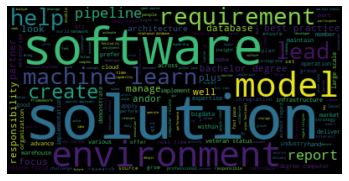

solution        2543
sql             1933
pipeline        1911
database        1775
cloud           1701
environment     1653
model           1624
python          1574
requirement     1570
software        1552
learn           1392
aws             1308
warehouse       1280
help            1214
relate          1208
time            1206
large           1201
make            1152
architecture    1149
create          1117
dtype: int64


Data Scientist


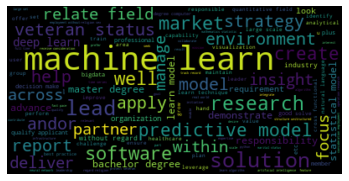

model          7871
learn          7682
machine        5127
solution       3787
statistical    3232
research       3179
apply          3090
help           2914
python         2829
insight        2665
statistic      2659
lead           2634
large          2559
make           2557
computer       2547
advance        2464
degree         2443
technique      2434
relate         2390
world          2321
dtype: int64


Business Analyst


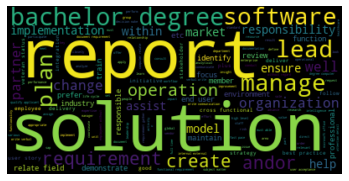

requirement      7103
solution         4080
user             3226
report           2934
plan             2240
document         2191
relate           2114
functional       2107
communication    1997
identify         1922
degree           1914
manage           1843
write            1841
level            1804
environment      1797
ensure           1792
create           1774
software         1736
analyze          1732
meet             1728
dtype: int64


Analyst


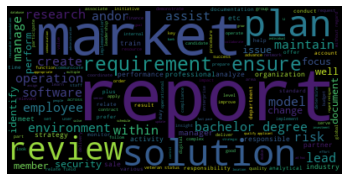

report            2165
requirement       1452
plan              1270
relate            1238
solution          1230
must              1216
level             1213
market            1190
perform           1166
degree            1142
environment       1112
employee          1111
ensure            1064
time              1017
responsibility    1014
status             992
may                979
employment         922
andor              910
operation          889
dtype: int64


Data Analyst


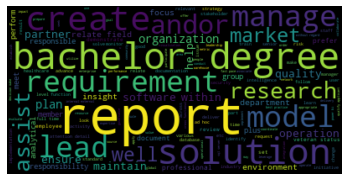

report         6476
requirement    3396
sql            2822
solution       2811
quality        2764
relate         2529
analyze        2478
database       2440
degree         2300
create         2181
model          2172
prefer         2167
perform        2064
write          2055
environment    2053
make           1991
time           1991
identify       1923
analytical     1885
must           1868
dtype: int64




In [31]:
from wordcloud import WordCloud
#collocations=False
# jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'AI',
#  'Data Analyst', 'Intern', 'Consultant', 'Business Intelligence', 'Sales',
#  'Workforce Analyst' ,'Cyber Security' ,'Researcher', 'Scientist',
#  'Data Modeler', 'Data Architect', 'Research Scientist',
#  'Machine Learning Scientist', 'Developer', 'Applied Scientist',
#  'Machine Learning Engineer', 'Big Data', 'Environmental Scientist',
#  'AI Engineer', 'Clinical Scientist', 'Computer Scientist', 'Engineer',
#  'Medical Scientist', 'Product Manager', 'Systems Engineer',
#  'Research Engineer', 'Machine Learning', 'Software Engineer',
#  'Applications Engineer', 'Cloud Engineer', 'Full Stack Engineer']


def fun(x):
    
    if x is None:
        return ""
    wordList.append(x)
    
jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'Data Analyst']

for job in jt:
    wordList=[]
    FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))   
    abc=" ".join(wordList)
    wordcloud = WordCloud().generate(abc)
    # Display the generated image:      
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    print(job)
    plt.show()
    words=pd.Series(abc.split())
    print(words.value_counts().sort_values(ascending=False).head(20))
    print("\n")
    

In [22]:
def remote(x):
    x=x.lower()
    if "remote" in x:
        r=1
    else:
        r=0
    return r

def part(x):
    x=x.lower()
    if "part-time" in x or "part time" in x:
        r=1
    else:
        r=0
    return r

def temp(x):
    x=x.lower()
    if "temp" in x:
        r=1
    else:
        r=0
    return r

def senior(x):
    x=x.lower()
    if "senior" in x or "sr" in x:
        r=1
    else:
        r=np.nan
    return r

FullDataSet['remote']=FullDataSet['Job Description'].dropna().apply(lambda x: remote(x))
FullDataSet['part-time']=FullDataSet['Job Description'].dropna().apply(lambda x: part(x))
FullDataSet['temp']=FullDataSet['Job Description'].dropna().apply(lambda x: temp(x))
FullDataSet['sen']=FullDataSet['Job Description'].dropna().apply(lambda x: senior(x))

In [23]:
print(FullDataSet['remote'].sum())
print(FullDataSet['part-time'].sum())
print(FullDataSet['temp'].sum())

1299.0
252.0
1042.0


In [24]:
FullDataSet[FullDataSet['temp']==1]

Job Title  \
8678   Operations Regulatory Control Change Lead Busi...   
8682                                    Business Analyst   
8684                                    Business Analyst   
8700                                    Business Analyst   
8711                                 Entry Level Analyst   
...                                                  ...   
26958                                     Data Scientist   
26979                                     Data Scientist   
26982  Senior Associate Scientist - Clinical & Diagno...   
27003     Machine Learning Engineer Virtual Hiring Event   
27004                                     Data Scientist   

                                         Job Description  \
8678   The Operations Regulatory Control (ORC) Change...   
8682   iHeartMedia is the number one audio company in...   
8684   Required:\n1. Bachelor's Degree in Information...   
8700   Job Description\nBusiness Analyst\nAnalyzes an...   
8711   Are you about to graduate and get your career ...   
...                                                  ...   
26958  About Seneca Resources:\nSeneca Resources is c...   
26979  We are data detectives and our job is difficul...   
26982  Why Patients Need You\n\n\nPfizer’s purpose is...   
27003  SAP Hiring Event!\n\nEvent Details\nDate: Tues...   
27004  Data Scientist (Big Data)\n\nLocation: Philade...   

                           Company Name           Location           City  \
8678                               Citi       New York, NY       New York   
8682                        iHeartRadio       New York, NY       New York   
8684   Crossfire Consulting Corporation       New York, NY       New York   
8700                  Black Systems LLC       New York, NY       New York   
8711             Phyton Talent Advisors       New York, NY       New York   
...                                 ...                ...            ...   
26958                  Seneca Resources        Norfolk, VA        Norfolk   
26979                         Q Systems      Palo Alto, CA      Palo Alto   
26982                            Pfizer    Pearl River, NY    Pearl River   
27003                               SAP  Newport Beach, CA  Newport Beach   
27004              Computer Enterprises   Philadelphia, PA   Philadelphia   

      State     Remote          Size  Founded  \
8678     NY  Uncertain    Very Large   1812.0   
8682     NY  Uncertain    Very Large   1972.0   
8684     NY  Uncertain         Small      NaN   
8700     NY  Uncertain  Medium-Small   2007.0   
8711     NY  Uncertain    Very Small      NaN   
...     ...        ...           ...      ...   
26958    VA  Uncertain         Small   2010.0   
26979    CA  Uncertain    Very Small      NaN   
26982    NY  Uncertain    Very Large   1849.0   
27003    CA  Uncertain    Very Large   1972.0   
27004    PA        Yes        Medium   1992.0   

                                  Industry  ...  Hourly  Junior  Senior   DF  \
8678   Investment Banking Asset Management  ...   False     NaN     NaN  DF1   
8682                                 Radio  ...   False     NaN     NaN  DF1   
8684                            Consulting  ...   False     NaN     NaN  DF1   
8700            Computer Hardware Software  ...   False     NaN     NaN  DF1   
8711                                   NaN  ...   False     NaN     NaN  DF1   
...                                    ...  ...     ...     ...     ...  ...   
26958               Staffing & Outsourcing  ...   False     NaN     NaN   DS   
26979            Health, Beauty, & Fitness  ...   False     NaN     NaN   DS   
26982            Biotech & Pharmaceuticals  ...   False     NaN     NaN   DS   
27003         Computer Hardware & Software  ...   False     NaN     NaN   DS   
27004                          IT Services  ...   False     NaN     NaN   DS   

                                     edit_jobDescription  \
8678   operation regulatory control orc change team p...   
8682   ihe

In [25]:
cities=pd.DataFrame(FullDataSet['City'].value_counts())
cities.head(50)

City
New York            1780
San Diego            871
Austin               806
Chicago              794
Houston              706
San Antonio          631
Seattle              626
Los Angeles          525
San Francisco        491
Philadelphia         475
Dallas               426
Phoenix              422
San Jose             298
Denver               247
Jacksonville         217
Sunnyvale            201
Irving               198
Salt Lake City       188
Santa Clara          176
Columbus             171
New York City        160
Tempe                148
Mountain View        143
Plano                142
Fort Worth           131
Menlo Park           115
Redmond              115
Palo Alto             98
Bellevue              95
Boulder               90
Scottsdale            89
Charlotte             84
Redwood City          84
Tampa                 84
Burbank               81
Wilmington            73
El Segundo            70
Lehi                  69
Orlando               64
Jersey City           58
Santa Monica          58
Miami                 56
San Mateo             53
Arlington             51
Chandler              51
Glendale              50
Brooklyn              49
Cambridge             48
Santa Clara Valley    48
Fremont               47

In [26]:
tables= pd.read_html('https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020&region=021', header=0)
cost_living=tables[1]
def splitter(x, i):
    return x.split(',')[i]
cost_living=cost_living[cost_living.City.str.contains("United States")] 
cost_living.reset_index(drop=True, inplace=True)
cost_living["Rank"]=cost_living.index+1
cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
cost_living["Country"]=cost_living.City.apply(lambda x: splitter(x,2))
cost_living["City"]=cost_living.City.apply(lambda x: splitter(x,0))
cost_living.count()
cost_living

<ipython-input-26-680448283021>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["Rank"]=cost_living.index+1
<ipython-input-26-680448283021>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
<ipython-input-26-680448283021>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Rank              City  Cost of Living Index  Rent Index  \
0      1          New York                100.00      100.00   
1      2     San Francisco                 91.51      115.58   
2      3         Anchorage                 91.36       38.94   
3      4          Honolulu                 89.70       63.03   
4      5          Brooklyn                 88.82       80.49   
5      6        Washington                 87.74       78.18   
6      7           Oakland                 86.51       79.55   
7      8           Seattle                 85.77       65.70   
8      9            Boston                 82.88       74.47   
9     10          Bellevue                 82.18       63.24   
10    11           Chicago                 80.18       58.64   
11    12          Sarasota                 79.26       46.44   
12    13      Philadelphia                 78.84       46.87   
13    14          San Jose                 78.64       83.34   
14    15          Portland                 78.63       49.42   
15    16       New Orleans                 78.46       41.29   
16    17        Sacramento                 77.00       46.21   
17    18       Minneapolis                 76.70       45.26   
18    19       Los Angeles                 76.55       72.90   
19    20            Albany                 75.44       33.00   
20    21      Jacksonville                 74.57       33.58   
21    22         Baltimore                 74.29       42.61   
22    23         San Diego                 74.22       66.83   
23    24             Miami                 74.16       57.56   
24    25           Buffalo                 73.92       28.28   
25    26           Atlanta                 73.89       46.82   
26    27              Reno                 73.85       38.22   
27    28        Pittsburgh                 73.61       35.86   
28    29            Denver                 73.30       51.98   
29    30         Nashville                 73.19       46.76   
30    31         Charlotte                 72.40       42.37   
31    32            Tucson                 72.12       26.44   
32    33           Olympia                 71.88       41.28   
33    34  Colorado Springs                 70.97       36.00   
34    35            Tacoma                 70.88       41.20   
35    36       Saint Louis                 70.78       28.97   
36    37          Columbus                 70.50       31.39   
37    38           Raleigh                 69.80       36.60   
38    39       Kansas City                 69.17       30.51   
39    40            Dallas                 68.03       47.05   
40    41            Austin                 67.79       52.04   
41    42         Las Vegas                 67.46       36.26   
42    43           Phoenix                 67.41       36.18   
43    44          Richmond                 67.20       33.88   
44    45             Tampa                 67.10       40.83   
45    46        Louisville                 66.72       28.71   
46    47      Indianapolis                 66.34       29.25   
47    48       San Antonio                 65.78       36.50   
48    49           Orlando                 65.70       41.51   
49    50           Houston                 65.13       42.70   
50    51    Salt Lake City                 64.76       36.83   
51    52           Madison                 64.67       38.11   
52    53             Tulsa                 64.28       26.38   
53    54           Detroit                 63.85       37.80   
54    55        Cincinnati                 61.64       33.99   
55    56             Boise                 60.71       34.47   
56    57       Little Rock                 59.76       26.39   
57    58           El Paso                 52.38       22.71   

    Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                           100.00           100.00                  100.00   
1                           103.02            86.91                  